# To make a better wedge

This notebook is an update to the notebook entitled "To make a wedge" featured in the blog post, [To make a wedge](https://agilescientific.com/blog/2013/12/12/to-make-a-wedge.html?rq=wedge), on December 12, 2013.

Start by importing Numpy and Matplotlib's pyplot module in the usual way:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the ricker wavelet function from [bruges](https://github.com/agile-geoscience/bruges):

In [2]:
from bruges.filters import ricker

## Make a wedge

In [3]:
from IPython.display import Image

Let's make a more generic wedge that will handle any 3 layer case we want to make.

In [4]:
Image('images/generic_wedge.png', width=600)

FileNotFoundError: No such file or directory: 'images/generic_wedge.png'

FileNotFoundError: No such file or directory: 'images/generic_wedge.png'

<IPython.core.display.Image object>

In [5]:
defaults = {'ta1':150, 'tb1':30, 'dta':50, 'dtb':50, 
            'xa1':100, 'xa2':100, 'dx':1,
            'mint':0, 'maxt': 600, 'dt':1,
            'minx':0, 'maxx': 500}

In [6]:
def make_upper_boundary(**kw):
    x = kw['maxx']-kw['minx']
    t0 = kw['ta1']
    x2 = np.arange(1, x-(kw['xa2']+kw['xa1']), kw['dx'])
    m2 = kw['dta']/x2[-1]
    seg1 = np.ones(int(kw['xa1']/kw['dx']))
    seg3 = np.ones(int(kw['xa2']/kw['dx']))
    seg2 =  x2 * m2
    interface = t0 + np.concatenate((seg1, seg2, kw['dta']+seg3))
    return interface

def make_lower_boundary(**kw):
    x = kw['maxx']-kw['minx']
    t1 = kw['ta1'] + kw['tb1']
    x2 = np.arange(1, x-(kw['xa2']+kw['xa1']), kw['dx'])
    m2 = (kw['dta']+kw['dtb'])/x2[-1]
    seg1 = np.ones(int(kw['xa1']/kw['dx']))
    seg3 = np.ones(int(kw['xa2']/kw['dx']))
    seg2 =  x2 * m2
    interface = t1 + np.concatenate((seg1, seg2, seg2[-1]+seg3))
    return interface

def make_wedge(kwargs):
    upper_interface = make_upper_boundary(**kwargs)
    lower_interface = make_lower_boundary(**kwargs)
    return upper_interface, lower_interface

def plot_interfaces(ax, upper, lower, **kw):
    ax.plot(upper,'-r')
    ax.plot(lower,'-b')
    ax.set_ylim(0,600)
    ax.set_xlim(kw['minx'],kw['maxx'])
    ax.invert_yaxis()


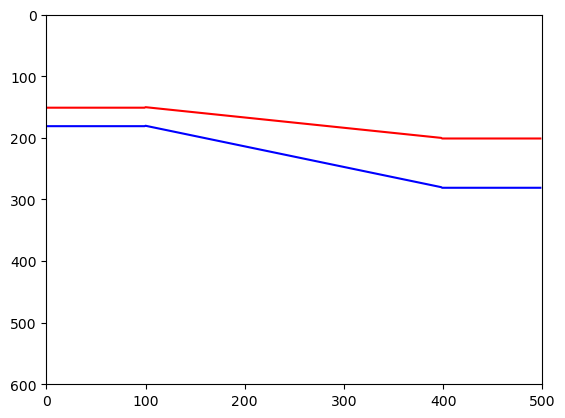

In [7]:
upper, lower = make_wedge(defaults)
f = plt.figure()
ax = f.add_subplot(111)
plot_interfaces(ax, upper, lower, **defaults)

In [8]:
def make_meshgrid(**kw):
    upper, lower = make_wedge(defaults)
    t = np.arange(kw['mint'], kw['maxt']-1, kw['dt'])
    x = np.arange(kw['minx'], kw['maxx']-1, kw['dx'])
    xv, yv = np.meshgrid(x, t, sparse=False, indexing='ij')
    return xv, yv

In [9]:
xv, yv = make_meshgrid(**defaults)

In [10]:
conditions = {'upper': yv.T < upper, 
              'middle': (yv.T >= upper) & (yv.T <= lower),
              'lower': yv.T > lower
             }

labels = {'upper': 1, 'middle':2, 'lower': 3}

In [11]:
d = yv.T.copy()
for name, cond in conditions.items():
    d[cond] = labels[name]

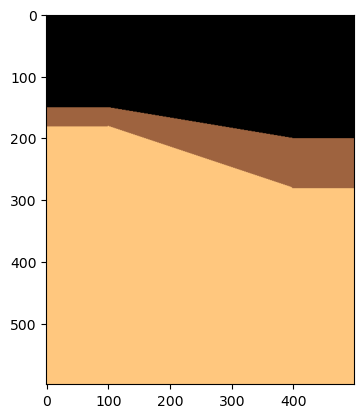

In [12]:
plt.imshow(d, cmap='copper')

In [13]:
vp = np.array([3300., 3200., 3300.]) 
rho = np.array([2600., 2550., 2650.]) 
AI = vp*rho
AI

array([8580000., 8160000., 8745000.])

In [14]:
model = d.copy()
model[model == 1] = AI[0]
model[model == 2] = AI[1]
model[model == 3] = AI[2]

In [15]:
def wvlt(f): 
    return ricker(0.512, 0.001, f)

def conv(a):
    return np.convolve(wvlt(f), a, mode='same')

Text(0.5, 1.0, 'Impedances')

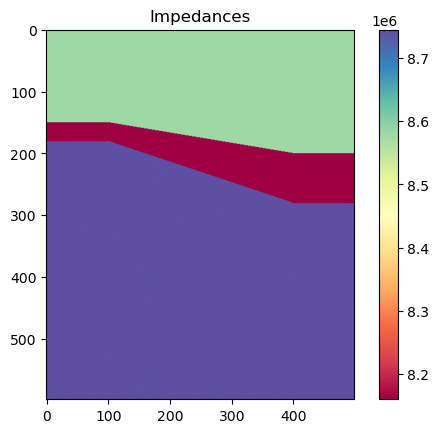

In [16]:
plt.imshow(model, cmap='Spectral')
plt.colorbar()
plt.title('Impedances')

# Plotting the synthetic

In [17]:
# These are just some plotting parameters

rc_params = {'cmap':'RdBu', 
             'vmax':0.05, 
             'vmin':-0.05, 
             'aspect':0.75}

txt_params = {'fontsize':12, 'color':'black',
              'horizontalalignment':'center',
              'verticalalignment':'center'}

tx = [0.85*defaults['maxx'],0.85*defaults['maxx'],0.85*defaults['maxx']]
ty = [(defaults['ta1'] + defaults['dta'])/2,
      defaults['ta1'] + defaults['dta'] + (defaults['dtb']/1.33),
      defaults['maxt']-(defaults['maxt'] - defaults['ta1'] - defaults['dta'] - defaults['dtb'])/2]

rock_names = ['shale1', 'sand', 'shale2']

In [18]:
defaults['ta1'], defaults['dta'], defaults['dtb']/1.25

(150, 50, 40.0)

In [19]:
rc = (model[1:] - model[:-1]) / (model[1:] + model[:-1])

We can make use of the awesome `apply_along_axis` in Numpy to avoid looping over all the traces. https://docs.scipy.org/doc/numpy/reference/generated/numpy.apply_along_axis.html 

ValueError: object too deep for desired array

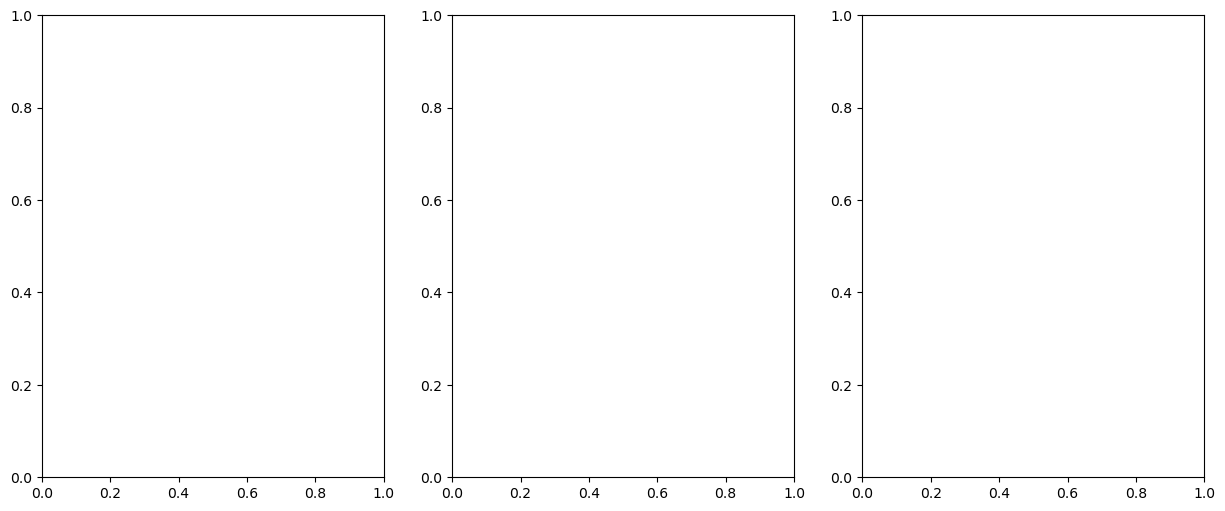

In [20]:
freqs = np.array([7,14,21])
f, axs = plt.subplots(1,len(freqs), figsize=(len(freqs)*5,6))
for i, f in enumerate(freqs):
    axs[i].imshow(np.apply_along_axis(conv, 0, rc), **rc_params)
    [axs[i].text(tx[j], ty[j], rock_names[j], **txt_params) for j in range(3)]
    plot_interfaces(axs[i], upper, lower, **defaults)
    axs[i].set_ylim(defaults['maxt'],defaults['mint'])
    axs[i].set_title( f'{f} Hz wavelet' )
    axs[i].grid(alpha=0.5)